# Ch06. 2개의 층을 연결합니다  -다층신경망
* 선형 회귀
* 로지스틱 회귀
* 단일층 신경망
> 경사 하강법
* 과대적합과 과소적합
> L1, L2규제

<br>

* 앞에서 배운 내용을 응용하고 확장하여 여러 층이 있는 모델을 만들어보겠습니다.<br><br>

**06-1** 신경망 알고리즘을 벡터화하여 한 번에 전체 샘플을 사용합니다<br>
**06-2** 2개의 층을 가진 신경망을 구현합니다<br>
**06-3** 미니 배치를 사용하여 모델을 훈련합니다

# 06-1 신경망 알고리즘을 벡터화하여 한 번에 전체 샘플을 사용합니다
사이킷런의 예제 데이터 세트는 2차원 배열로 저장되어 있습니다. 2차원 배열은 행을 샘플, 열을 특성으로 생각하면 행렬로 이해할 수 있습니다.<br>행렬 개념을 신경망 알고리즘에 도입할 것입니다.

## 벡터화된 연산은 알고리즘의 성능을 올립니다
<br>

넘파이, 머신러닝, 딥러닝 패키지들은 다차원 배열의 계산, 즉 행렬 연산을 빠르게 수행할 수 있습니다.<br>
**배치 경사 하강법**을 SingleLayer 클래스에 적용하면 벡터화된 연산을 사용할 수 있습니다.
<br><br>
지금까지 선형 회귀, 로지스틱 회귀, SingleLayer 클래스에서는 **확률적 경사 하강법**을 사용했습니다. 확률적 경사 하강법은 가중치를 1번 업데이트 할 때 1개의 샘플을 사용하므로 손실함수의 전역 최솟값을 불안정하게 찾습니다. **배치 경사 하강법**은 전역 최솟값을 안정적으로 찾지만, 알고리즘 1번 수행당 계산 비용이 많이 듭니다.

## 벡터 연산과 행렬 연산을 알아봅니다
* 점 곱 (스칼라 곱)

단일층 신경망<br>
![그림1]()

단일층 신경망 SingleLayer 클래스의 forpass() 메서드에 z 구현

In [ ]:
z=np.sum(x*self.w)+self.b # 넘파이의 원소별 곱셈

In [1]:
import numpy as np

x=np.array([1,2,3])
w=np.array([4,5,6])
x*w

array([ 4, 10, 18])

In [2]:
np.sum(x*w)

32

여기서 $\mathbf{x}(x_1,x_2,\cdots )$와 $\mathbf{w}(w_1,w_2,\cdots )$는 벡터라고 부르고 벡터는 볼드로 표기합니다.<br>그리고 위의 두 벡터를 곱하여 합을 구하는 계산(np.sum(x\*self.w)) 을 **점 곱(dot product)** 또는 **스칼라 곱(scalar product)**이라고 합니다.

![그림2]()

<br><br><br>
* 점 곱을 행렬 곱셈으로 표현

![그림3]()

점 곱을 행렬 곱셈으로 표현하면 행 방향으로 놓인 첫 번째 벡터와 열 방향으로 놓인 두 번째 벡터의 원소를 각각 곱한 후 모두 더하는 것과 같습니다.<br>앞의 np.sum(x\*self.w)의 계산과 정확히 일치합니다. 넘파이에서 행렬 곱셈을 계산하는 함수를 사용하면 np.sum(x\*w)를 다음과 같이 수정할 수 있습니다.

In [4]:
np.dot(x,w)

32

위 행렬의 곱셈 원리를 훈련 데이터의 전체 샘플에 대해 적용하면 배치 경사 하강법을 구현할 수 있습니다.

<br><br><br>
* 전체 샘플에 대한 가중치 곱의 합을 행렬 곱셈으로 구하기

훈련데이터의 샘플은 각 샘플이 하나의 행으로 이루어져 있으므로 행렬 곱셈을 적용하면 샘플의 특성과 가중치를 곱하여 더한 행렬을 얻을 수 있습니다. <br><br>
$$\mathbf{XW}=\begin{bmatrix}
x_1^{(1)} & x_2^{(1)} & x_3^{(1)}\\ 
x_1^{(2)} & x_2^{(2)} & x_3^{(2)}\\ 
 & \vdots  & \\ 
x_1^{(m)} & x_2^{(m)} & x_3^{(m)}
\end{bmatrix}\begin{bmatrix}
w_1\\ 
w_2\\ 
w_3
\end{bmatrix}=\begin{bmatrix}
x_1^{(1)}w_1+x_2^{(1)}w_2+x_3^{(1)}w_3\\ 
x_1^{(2)}w_1+x_2^{(2)}w_2+x_3^{(2)}w_3\\ 
\vdots \\ 
x_1^{(m)}w_1+x_2^{(m)}w_2+x_3^{(m)}w_3
\end{bmatrix}$$
<br>
$$샘플 m개$$
<br>
행렬 곱셈을 통해 만들어지는 행렬의 크기는 첫 번째 행렬의 행과 두 번째 행렬의 열이 됩니다. 크기는 다음과 같이 표기합니다.
<br>
$$(m,n)\cdot (n,k)=(m,k)$$
<br>
위의 $\mathbf{XW}$의 경우에는 $(m,3)\cdot (3,1)=(m,1)$가 됩니다.

## SingleLayer 클래스에 배치 경사 하강법 적용하기
#### ① 넘파이와 맷플롯립 임포트

In [5]:
import numpy as np
import matplotlib.pyplot as plt

#### ② 위스콘신 유방암 데이터 세트를 나눕니다

In [6]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, 
                                                            test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, 
                                                  test_size=0.2, random_state=42)

#### ③ 훈련세트와 검증세트 크기 확인
샘플 569개, 특성 30개

In [9]:
print(x_train_all.shape, x_test.shape)

(455, 30) (114, 30)


In [10]:
print(x_train.shape, x_val.shape)

(364, 30) (91, 30)


#### ④ 정방향 계산을 행렬 곱셈으로 표현
정방향 계산을 행렬 곱셈으로 표현한 것입니다.
$$\mathbf{XW+b}=\begin{bmatrix}
x_1^{(1)} &\cdots   &x_{30}^{(1)} \\ 
 \vdots &  & \vdots \\ 
x_1^{(364)} & \cdots & x_{30}^{(364)}
\end{bmatrix}\begin{bmatrix}
w_1\\ 
w_2\\ 
\vdots\\ 
w_{30}
\end{bmatrix}+\begin{bmatrix}
b\\ 
\vdots \\ 
b
\end{bmatrix}=\begin{bmatrix}
z^{(1)}\\ 
z^{(2)}\\ 
\vdots \\ 
z^{(364)}
\end{bmatrix}$$

넘파이를 사용하면 절편을 더하기 위해 (364,1) 크기의 행렬을 따로 만들 필요가 없습니다.<br>
행렬에 스칼라 값을 더하면 자동으로 행렬의 각 요소에 스칼라 값을 더해 줍니다.
![그림4]()

####  ⑤ 그레이디언트 계산
그레이디언트 : 오차와 입력 데이터의 곱
$$\mathbf{X^{T}E}=\begin{bmatrix}
x_1^{(1)} &\cdots   &x_1^{(364)} \\ 
x_2^{(1)} &\cdots  &x_2^{(364)} \\ 
 \vdots &  & \vdots \\ 
x_{30}^{(1)} & \cdots & x_{30}^{(364)}
\end{bmatrix}\begin{bmatrix}
e^{(1)}\\ 
e^{(2)}\\ 
\vdots \\ 
e^{(364)}
\end{bmatrix}=\begin{bmatrix}
g_1\\ 
g_2\\ 
\vdots \\ 
g_{30}
\end{bmatrix}$$
<br>
$\mathbf{X^T}$ :$\mathbf{X}$의 전치행렬<br>
행렬의 크기는 $(30,364)\cdot (364,1)=(30,1)$이 됩니다.<br>
$g_1$은 모든 샘플의 첫 번째 특성과 오차를 곱하여 더한 값이므로 이후 그레이디언트 평균값을 계산할 때 이 값을 다시 전체 샘플 수로 나눕니다.

#### ⑥ forpass(), backprop() 메서드에 배치 경사 하강법 적용
forpass() 메서드에는 np.sum() 대신 np.dot() 함수를 사용하고, <br>
backprop() 메서드에서는 전체 샘플 개수로 평균 그레이디언트를 구합니다.

In [ ]:
def forpass(self, x):
    z=np.dot(x,self.w)+self.b
    return z

def backprop(self, x, err):
    m=len(x)  #넘파이 배열의 행 크기 반환
    w_grad = np.dot(x.T, err) / m
    b_grad = np.sum(err) / m
    return x_grad, b_grad

#### ⑦ fit() 메서드 수정
배치 경사 하강법에서는 forpass()와 backprop() 메서드에서 전체 샘플을 한꺼번에 계산하므로 for 문이 하나 삭제됩니다.

In [ ]:
def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)                  # 타깃을 열 벡터로 바꿉니다.
        y_val = y_val.reshape(-1, 1)          # 검증용 타깃을 열 벡터로 바꿉니다.
        m = len(x)                            # 샘플 개수를 저장합니다.
        self.w = np.ones((x.shape[1], 1))     # 가중치를 초기화합니다.
        self.b = 0                            # 절편을 초기화합니다.
        self.w_history.append(self.w.copy())  # 가중치를 기록합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
            z = self.forpass(x)               # 정방향 계산을 수행합니다.
            a = self.activation(z)            # 활성화 함수를 적용합니다.
            err = -(y - a)                    # 오차를 계산합니다.
            # 오차를 역전파하여 그래디언트를 계산합니다.
            w_grad, b_grad = self.backprop(x, err)
            # 그래디언트에서 페널티 항의 미분 값을 더합니다. 
            w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m
            # 가중치와 절편을 업데이트합니다.
            self.w -= self.lr * w_grad
            self.b -= self.lr * b_grad
            # 가중치를 기록합니다.
            self.w_history.append(self.w.copy())
            # 안전한 로그 계산을 위해 클리핑합니다.
            a = np.clip(a, 1e-10, 1-1e-10)
            # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)

활성화함수 출력값인 a가 열 벡터이므로 타깃값을 (m,1)인 열 벡터로 변환하였고 평균 손실을 구하기 위해 np.sum() 함수로 각 함수의 손실을 더한 후 전체 샘플의 개수로 나눴습니다.

#### ⑧ 나머지 메서드 수정
predict() 메서드와 update_val_loss() 메서드

In [ ]:
def predict(self, x):
    z = self.forpass(x)      # 정방향 계산을 수행합니다.
    return z > 0             # 스텝 함수를 적용합니다.

def update_val_loss(self, x_val, y_val):
    z = self.forpass(x_val)            # 정방향 계산을 수행합니다.
    a = self.activation(z)             # 활성화 함수를 적용합니다.
    a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
    # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
    val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

전체 코드는 다음과 같습니다.

In [11]:
class SingleLayer:
    
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None              # 가중치
        self.b = None              # 절편
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.w_history = []        # 가중치 기록
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터

    def forpass(self, x):
        z = np.dot(x, self.w) + self.b        # 선형 출력을 계산합니다.
        return z

    def backprop(self, x, err):
        m = len(x)
        w_grad = np.dot(x.T, err) / m         # 가중치에 대한 그래디언트를 계산합니다.
        b_grad = np.sum(err) / m              # 절편에 대한 그래디언트를 계산합니다.
        return w_grad, b_grad

    def activation(self, z):
        a = 1 / (1 + np.exp(-z))              # 시그모이드 계산
        return a
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)                  # 타깃을 열 벡터로 바꿉니다.
        y_val = y_val.reshape(-1, 1)
        m = len(x)                            # 샘플 개수를 저장합니다.
        self.w = np.ones((x.shape[1], 1))     # 가중치를 초기화합니다.
        self.b = 0                            # 절편을 초기화합니다.
        self.w_history.append(self.w.copy())  # 가중치를 기록합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
            z = self.forpass(x)               # 정방향 계산을 수행합니다.
            a = self.activation(z)            # 활성화 함수를 적용합니다.
            err = -(y - a)                    # 오차를 계산합니다.
            # 오차를 역전파하여 그래디언트를 계산합니다.
            w_grad, b_grad = self.backprop(x, err)
            # 그래디언트에서 페널티 항의 미분 값을 더합니다.
            w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m
            # 가중치와 절편을 업데이트합니다.
            self.w -= self.lr * w_grad
            self.b -= self.lr * b_grad
            # 가중치를 기록합니다.
            self.w_history.append(self.w.copy())
            # 안전한 로그 계산을 위해 클리핑합니다.
            a = np.clip(a, 1e-10, 1-1e-10)
            # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)
    
    def predict(self, x):
        z = self.forpass(x)      # 정방향 계산을 수행합니다.
        return z > 0             # 스텝 함수를 적용합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == y.reshape(-1, 1))
    
    def reg_loss(self):
        # 가중치에 규제를 적용합니다.
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
    
    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)            # 정방향 계산을 수행합니다.
        a = self.activation(z)             # 활성화 함수를 적용합니다.
        a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
        # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
        val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

#### ⑨ 훈련 데이터 표준화 전처리
안정적인 학습을 위해서 데이터 세트의 특성을 평균이 0, 표준편차가 1이 되도록 변환합니다.<br>
5장에서 사용했던 사이킷런의 StandardScaler 클래스를 사용합니다.
StandardScaler 클래스 이외에도 데이터 전처리에 관련된 클래스들은 sklearn.preprocessing 모듈 아래에 있으며 이런 클래스들을 변환기라고 부릅니다.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

#### ⑩ 표준화 데이터를 SingleLayer 클래스 객체에 전달하여 배치 경사 하강법 적용

In [13]:
single_layer = SingleLayer(l2=0.01)
single_layer.fit(x_train_scaled, y_train, 
                 x_val=x_val_scaled, y_val=y_val, epochs=10000)
single_layer.score(x_val_scaled, y_val)

0.978021978021978

L2규제 매개변수의 값을 0.01로 지정, <br>
확률적 경사 하강법과 배치 경사 하강법은 가중치 업데이트 횟수에 차이가 있기 때문에 에포크 값을 10000으로 증가시킵니다.

#### ⑪ 검증 세트로 성능 측정하고 그래프로 비교
score() 메서드에서 출력된 검증 세트의 점수는 5장과 동일하지만 손실 함수 값의 변화는 다릅니다.

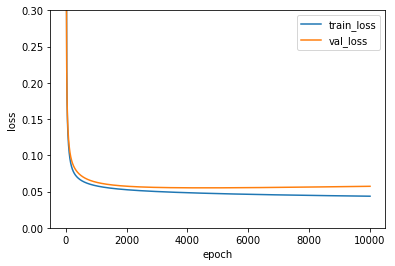

In [14]:
plt.ylim(0, 0.3)
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

배치 경사 하강법은 전체 샘플을 사용하여 가중치를 업데이트하기 때문에 손실값이 안정적으로 감소합니다.

#### ⑫ 가중치의 변화 그래프

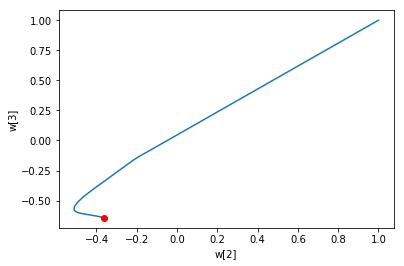

In [15]:
w2 = []
w3 = []
for w in single_layer.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

가중치의 변화가 연속적이므로 손실값도 안정적으로 수렴됩니다. 하지만 배치 경사 하강법은 매번 전체 훈련 세트를 사용하므로 연산 비용이 많이 들고 최솟값에 수렴하는 시간도 많이 걸립니다. 